## **Multi-armed bandit problem**

### Reinforcement learning

**MDP** - Markov Decision Processes

$\;s_t$ - current state\
$\;o_t$  - obesrvation made in $s_t$\
$\;a_t$ - decision made from state $s_t$

$\quad a_t \in \{0, 1, 2, ..., n\}$, where\
$\quad \quad n $= number of machines


### **Q-learning algorithm**

In [5]:
import sys
sys.path.append('../')

In [6]:
import numpy as np
from src.bandit import Bandit

In [43]:
iterations = 5000
episode_iterations = 1000
n_bandits = 20
exploration_prob = 1  # initial exploration probability
exploration_decay = 0.001
min_exploration_prob = 0.01
gamma = 0.99  # discount factor
lr = 0.1

q_table = np.zeros((n_bandits, 1))

bandits_probs = np.random.randint(20, 100, n_bandits) / 100
env = Bandit(bandits_probs)

In [44]:
total_rewards = []

In [45]:
def q_table_update_value(q_table, action, reward):
    return q_table[action] + lr * (reward - q_table[action])

for n in range(iterations):
    action = np.random.randint(n_bandits)

    total_episode_reward = 0

    for i in range(episode_iterations):
        
        if np.random.uniform(0, 1) < exploration_prob:
            action = np.random.randint(n_bandits)
        else:
            action = np.argmax(q_table)

        reward = env.pull(action)
        q_table[action] += q_table_update_value(q_table, action, reward)
        total_episode_reward += reward

    
    exploration_prob = max(min_exploration_prob, np.exp(-exploration_decay*n))
    total_rewards.append(total_episode_reward)

/tmp/ipykernel_26431/2058361475.py:17: RuntimeWarning: overflow encountered in add
  q_table[action] += q_table_update_value(q_table, action, reward)
/tmp/ipykernel_26431/2058361475.py:2: RuntimeWarning: invalid value encountered in add
  return q_table[action] + lr * (reward - q_table[action])


Text(0.5, 1.0, 'Suma nagród w epizodzie \n           liczba maszyn = 20, liczba iteracjiw epizodzie = 1000')

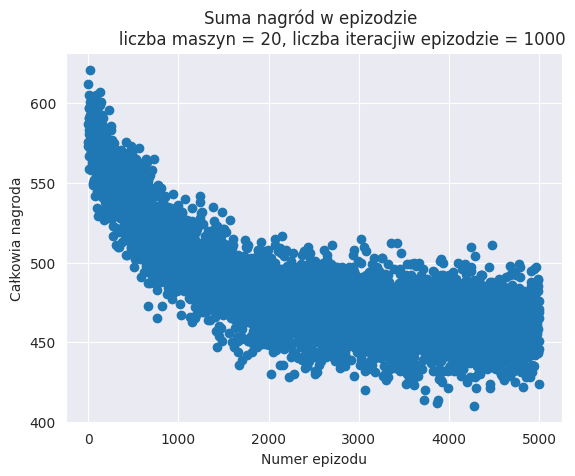

In [46]:
import matplotlib.pyplot as plt
plt.scatter(y=total_rewards, x=range(len(total_rewards)))
plt.xlabel('Numer epizodu')
plt.ylabel('Całkowia nagroda')
plt.title(f'Suma nagród w epizodzie \n\
           liczba maszyn = {n_bandits}, liczba iteracjiw epizodzie = {episode_iterations}')

Text(0, 0.5, 'Średnia nagroda')

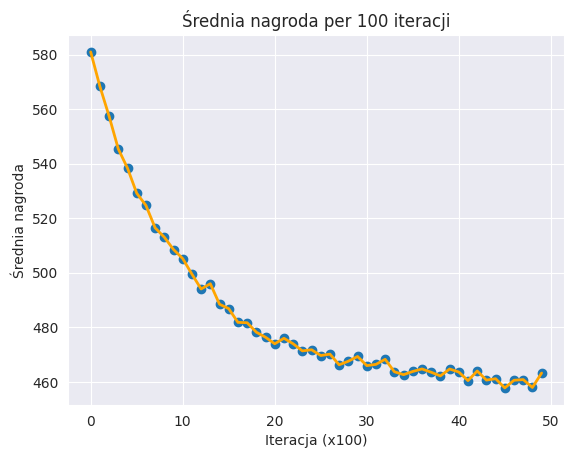

In [47]:
summary_seed = 100
summed_up_rewards = [np.mean(total_rewards[summary_seed*i:summary_seed*(i+1)])\
                      for i in range(iterations // summary_seed)]

plt.plot(summed_up_rewards, color='orange', linewidth=2)
plt.scatter(y=summed_up_rewards, x=range(len(summed_up_rewards)))
plt.title(f'Średnia nagroda per {summary_seed} iteracji')
plt.xlabel(f'Iteracja (x{summary_seed})')
plt.ylabel('Średnia nagroda')

## **Contextual Multi Armed Bandit**

**$N$**  - bandits (ads to show on a website)\
**$k$** - context, k type of customer visiting online store website

**$M$** = $matrix_{kxN}$

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

torch.manual_seed(42)
random.seed(42)

In [55]:
context_size = 10
n_bandits = 20
GAMMA = 0.9
EPSILON = 0.1
LEARNING_RATE = 1e-3

In [61]:
class DQN(nn.Module):
    def __init__(self, num_arms, context_size):
        super(DQN, self).__init__()
        self.num_arms = num_arms
        self.context_size = context_size
        self.fc1 = nn.Linear(context_size, 64)
        self.fc2 = nn.Linear(64, num_arms)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DQN(num_arms=n_bandits, context_size=context_size)

In [57]:
class CMAB:
    def __init__(self, n_arms: int, context_size: int) -> None:
        '''
        :param int n_arms: number of bandits
        :param int context_size: size of the context

        :return None:
        '''
        assert n_arms > 2, 'Fewer than 2 bandits'
        self.probs = np.random.randint(2, 10, (n_arms, context_size)) / 10


    def pull(self, arm_idx: int, context: int) -> int:
        '''
        Function return the reward for the pull of the give arm of the bandit
        in a give context

        :param arm_idx: index of the bandit to be used
        :param context: context of the bandit to be used

        :return int: 1 if success, 0 if failure
        '''
        return 1 if np.random.uniform(0, 1) < self.probs[arm_idx][context] else 0

In [58]:

class Agent:
    def __init__(self, num_arms, context_size, epsilon=0.1, learning_rate=0.01, gamma=0.99):
        self.num_arms = num_arms
        self.context_size = context_size
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_history = []

        self.enviroment = CMAB(num_arms, context_size)
        self.q_network = DQN(num_arms, context_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

    def select_action(self, context, rewards):
        input_tensor = self.one_hot(context).float().reshape(1, -1).to(self.device)
        if random.random() < self.epsilon:
            # explore
            action = random.randint(0, self.num_arms - 1)
        else:
            # exploit
            with torch.no_grad():
                q_values = self.q_network(input_tensor)
                action = torch.argmax(q_values).item()

        return action

    def update_network(self, context, action, reward):
        input_tensor = self.one_hot(context).float().to(self.device)
        q_values = self.q_network(input_tensor)

        target_q = reward + self.gamma * torch.max(q_values).item()
        q_values[action] = target_q

        # backprop
        loss = nn.MSELoss()(q_values, self.q_network(input_tensor))
        self.loss_history.append(loss.item())
        self.optimizer.zero_grad()
        torch.autograd.set_detect_anomaly(True)
        loss.backward()
        self.optimizer.step()

    def one_hot(self, idx):
        return torch.eye(self.context_size)[idx]

    def get_context(self):
        return np.random.randint(0, self.context_size)

    def pull_arm(self, arm_idx, context):
        reward = self.enviroment.pull(arm_idx, context)
        return reward
    
    def train(self, episodes):
        for _ in tqdm(range(episodes)):
            context = self.get_context()
            rewards = [0] * self.num_arms
            action = self.select_action(context, rewards)

            reward = self.pull_arm(action, context)
            rewards[action] = reward

            self.update_network(context, action, reward)


agent = Agent(num_arms=n_bandits, context_size=context_size, learning_rate=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON)

agent.train(10000)

100%|██████████| 10000/10000 [00:48<00:00, 205.30it/s]


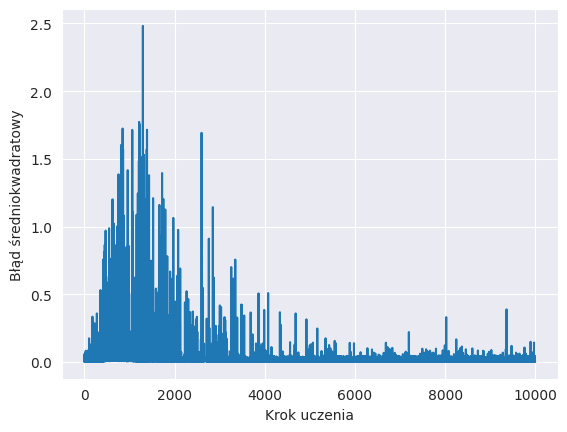

In [59]:
sns.set_style('darkgrid')
plt.plot(agent.loss_history)
plt.xlabel('Krok uczenia')
plt.ylabel('Błąd średniokwadratowy')
plt.show()

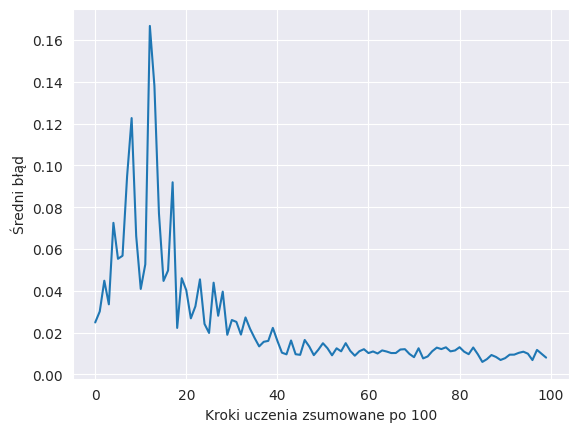

In [60]:
group_by_n = 100
avg_loss = [np.average(agent.loss_history[i:i+group_by_n]) for i in \
            range(0, len(agent.loss_history), group_by_n)]


sns.set_style('darkgrid')
plt.plot(avg_loss)
plt.xlabel('Kroki uczenia zsumowane po {}'.format(group_by_n))
plt.ylabel('Średni błąd')
plt.show()

In [19]:
def inference(agent, sample_size=1000):
    """
    Function to evaluate the performance of the agent.
    :param agent: The agent to be evaluated
    :param sample_size: Number of episodes to evaluate the agent

    :return None:
    """
    model.eval()
    total_reward = 0
    with torch.no_grad():
        for i in range(sample_size):

            context = agent.get_context()
            preds = agent.q_network(agent.one_hot(context).float())
            idx = torch.argmax(preds).item()
            total_reward += agent.pull_arm(idx, context)
    
    return total_reward / sample_size

#### **Comparison between sampled result and average result ypu can get from the enviroment**

In [20]:
print(f'Trained agent\'s winning rate over {1000} episodes: {inference(agent)} ')
print(f'Average probability of enviroment for all possible agents {np.average(agent.enviroment.probs)}')

Trained agent's winning rate over 1000 episodes: 0.842 
Average probability of enviroment for all possible agents 0.5359999999999999
